# ML application is an Art (recap).
How to prepare data? What data to use? How to select a model? How to quantify a a model quality?

# What is a good model? (Intuitively, supervised learning)
1. (no brainer) Predicts well the training objects (fits plot).
2. Predicts well new objects - "finds the underlying laws".

# Loss
Metric depends on the domain - it's up to user to define what is a good prediction. (See the lecture tomorrow)

# Overfitting vs. underfitting

In [1]:
screen_width, plot_height = 15, 10
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(2345)
X = np.random.uniform(low=-10, high=10, size=20)
a = 1e-1
b = 17
def Y_ideal(x):
    return a*x**3 + b*np.abs(x)
Y = Y_ideal(X) + np.random.normal(size=X.size, scale=15)
demo_degrees = (1, 15)
fit_by_degree = map(lambda degree: np.polyfit(X, Y, deg=degree), demo_degrees)
x_space = np.linspace(X.min(), X.max(), num=200)

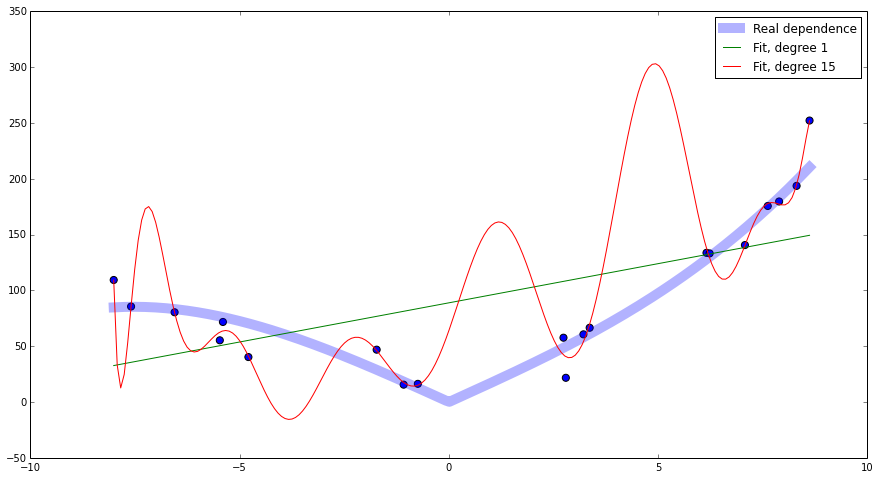

In [3]:
fig, ax = pl.subplots(figsize=(screen_width, 8))
ax.scatter(X, Y, s=50)
ax.plot(x_space, Y_ideal(x_space), lw=10, alpha=0.3, label="Real dependence")
for degree, fit in zip(demo_degrees, fit_by_degree):
    ax.plot(x_space, np.poly1d(fit)(x_space), label="Fit, degree %d" % degree)
_ = ax.legend()

# Overfitting vs. underfitting
Solution: cross-validation + regularization + model compelxity constraints.

# Toy example
Let's generate some 1D noisy data.

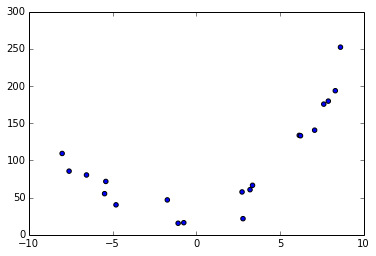

In [4]:
np.random.seed(2345)
X = np.random.uniform(low=-10, high=10, size=20)
a = 1e-1
b = 17
def Y_ideal(x):
    return a*x**3 + b*np.abs(x)
Y = Y_ideal(X) + np.random.normal(size=X.size, scale=15)
fig, ax = pl.subplots()
ax.scatter(X, Y)

We'll use polynomial fits with MSE error - I guess everybody here has experience with them. Let's plot the fitted polynomials for different degrees.

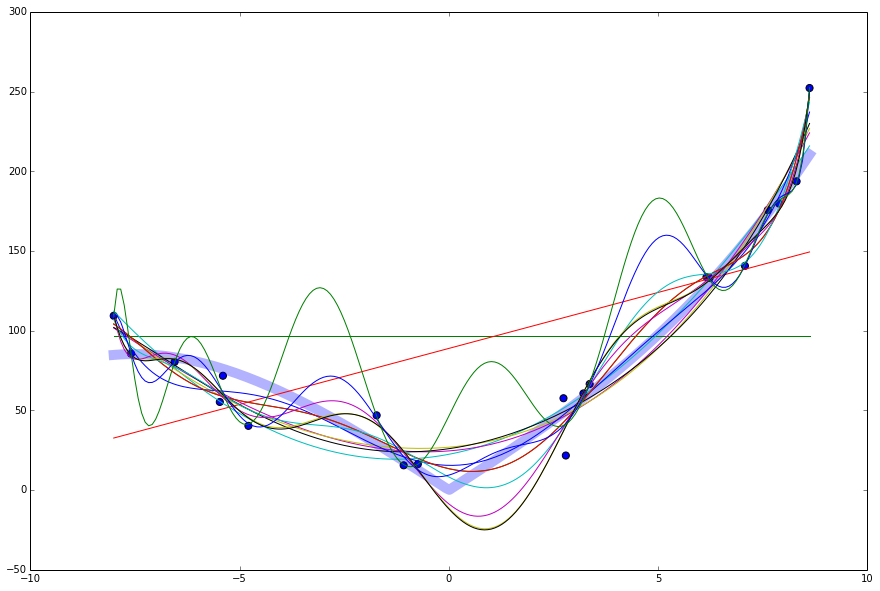

In [5]:
fig, ax = pl.subplots(figsize=(screen_width, plot_height))
ax.scatter(X, Y, s=50)
fit_by_degree = map(lambda degree: np.polyfit(X, Y, deg=degree), xrange(0, 15))
x_space = np.linspace(X.min(), X.max(), num=200)
ax.plot(x_space, Y_ideal(x_space), lw=10, alpha=0.3)
for degree, fit in enumerate(fit_by_degree):
    ax.plot(x_space, np.poly1d(fit)(x_space))

Now let's compare two things: MSE between the fit and the points (our loss function) and the integrated MSE between the real and the fitted distribution.

$E = \frac{\int_{x_\text{min}}^{x_\text{max}} (f(x) - g(x))^2dx}{x_\text{max} - x_\text{min}}$;
$f(x) = ax^3 + b|x|$;
$g(x) = \sum_{i=0}^N q_i x^i$

$p_i = \begin{cases}
   q_i,& \text{if $i \neq 3 \neq 1$} \\
   q_i - a,& \text{if $i = 3$} \\
   q_i - b, &\text{if $i = 1$}
   \end{cases}
   $

$n_i = \begin{cases}
   q_i, &\text{if $i \neq 3 \neq 1$} \\
   q_i - a, &\text{if $i = 3$} \\
   q_i + b,& \text{if $i = 1$}
   \end{cases}
   $

$E = \frac{1}{x_\text{max}- x_\text{min}} \left( -  \sum_{i, j = 0}^N \frac{n_i n_j x_\text{min}^{i+j+1}}{i+j+1} + \sum_{i, j = 0}^N \frac{p_i p_j x_\text{max}^{i+j+1}}{i+j+1} \right) = 
\frac{1}{x_\text{max}- x_\text{min}} \sum_{i, j = 0}^N \frac{p_i p_j x_\text{max}^{i+j+1} - n_i n_j x_\text{min}^{i+j+1}}{i+j+1}$

In [6]:
fit_by_degree = map(lambda degree: np.polyfit(X, Y, deg=degree), xrange(0, 17))
from itertools import imap
def get_model_MSE(coefficients):
    v = X.max() - X.min()
    common = np.zeros(max(len(coefficients), 4))
    common[:len(coefficients)] = coefficients[::-1]
    common[3] -= a
    n = common.copy()
    p = common.copy()
    n[1] += b
    p[1] -= b
    divisors = np.concatenate(map(
        lambda shift: np.arange(shift, shift+len(common))[:, np.newaxis],
        xrange(len(common))), axis=1) + 1
    x_min_int = np.power(X.min(), divisors) * np.dot(n[:, np.newaxis], n[:, np.newaxis].T),               
    x_max_int = np.power(X.max(), divisors) * np.dot(p[:, np.newaxis], p[:, np.newaxis].T)
    return np.true_divide(np.sum(np.true_divide(x_max_int - x_min_int, divisors)), v)

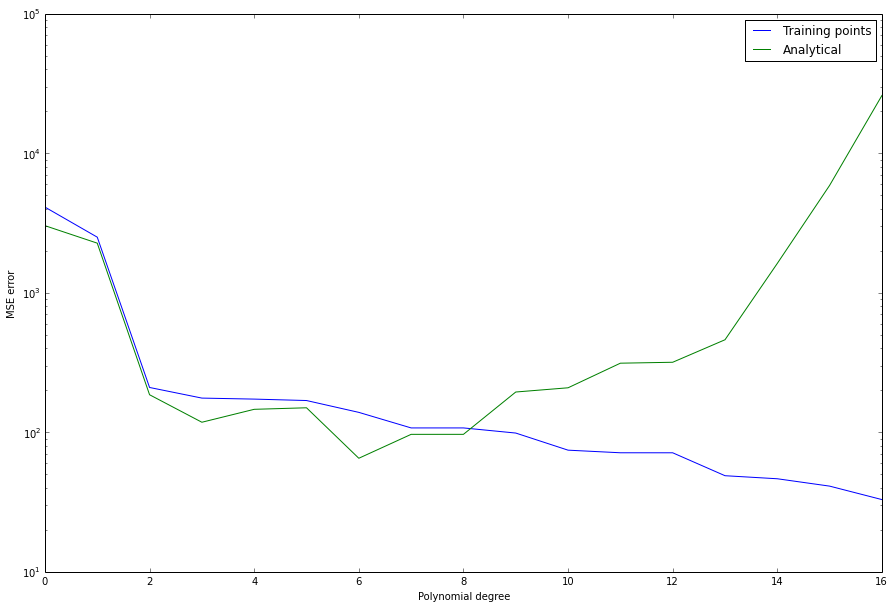

In [7]:
def get_fit_MSE(coefficients, x, y):
    return ((y - np.poly1d(coefficients)(x))**2).mean()
MSE_points_error = map(lambda fit: get_fit_MSE(fit, X, Y), fit_by_degree)
MSE_real = map(get_model_MSE, fit_by_degree)
fig, ax = pl.subplots(figsize=(screen_width, plot_height))
ax.plot(range(len(MSE_points_error)), MSE_points_error, label='Training points')
ax.plot(range(len(MSE_real)), MSE_real, label='Analytical')
ax.set_yscale('log')
ax.set_ylabel("MSE error")
ax.set_xlabel("Polynomial degree")
ax.legend()

# Validation
We need to know how good is the model. As seen above, MSE of the fit is a bad measure. 
## Holdout validation
Select a part of the dataset, train the model, predict and score on the other part.

In [8]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
def get_holdout_MSE_error(degree, seed):
    # Note, that by using a constant random seed, we ensure that train and test
    # sets are the same for every degree
    train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.3, random_state=seed)
    fit = np.polyfit(train_x, train_y, deg=degree)
    return mean_squared_error(test_y, np.poly1d(fit)(test_x))
seeds = (39, 213)
from itertools import product
degrees_for_holdout = 14
MSE_holdout_by_seed = map(lambda (seed, degree): get_holdout_MSE_error(degree, seed),
                          product(seeds, xrange(degrees_for_holdout)))

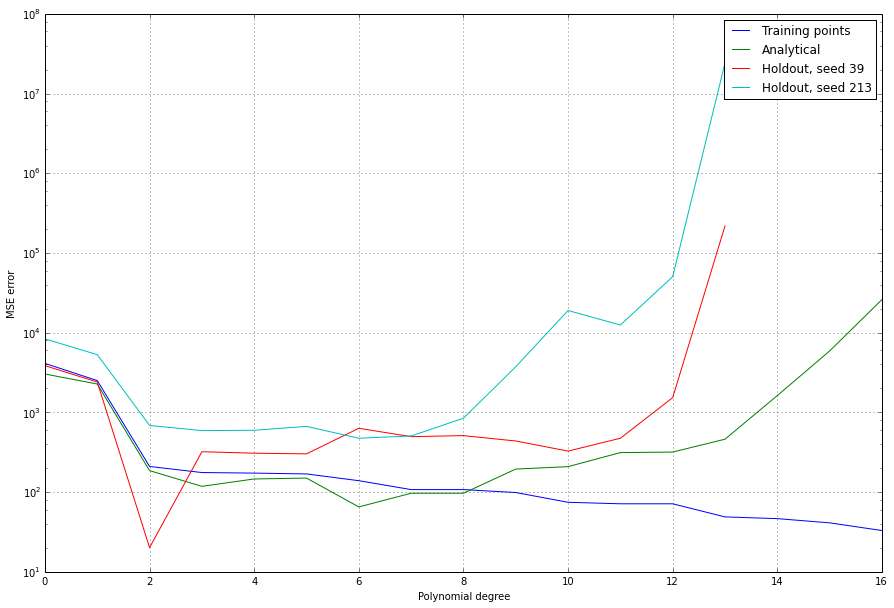

In [9]:
fig, ax = pl.subplots(figsize=(screen_width, plot_height))
ax.plot(range(len(MSE_points_error)), MSE_points_error, label='Training points')
ax.plot(range(len(MSE_real)), MSE_real, label='Analytical')
for index, seed in enumerate(seeds):
    ax.plot(range(degrees_for_holdout),
            MSE_holdout_by_seed[index*degrees_for_holdout:(index+1)*degrees_for_holdout],
            label='Holdout, seed %d' % seed)
ax.set_yscale('log')
ax.set_ylabel("MSE error")
ax.set_xlabel("Polynomial degree")
ax.grid()
ax.legend()

Summary: unstable, easy to calculate.

## K-fold cross-validation
The most common. Split dataset into k consecutive folds. Each fold is then used a validation set once while the k - 1 remaining fold form the training set.
SELF
http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.KFold.html#sklearn.cross_validation.KFold

## Leave-one-out (LOO)
For every object train on all except it, predict and score on the object.
http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.LeaveOneOut.html
SELF

# Regularization
Before, to prevent overfitting we rigidly restricted the model complexity. We also can add regularization - penalty for complexity.
http://openclassroom.stanford.edu/MainFolder/DocumentPage.php?course=MachineLearning&doc=exercises/ex5/ex5.html

In [10]:
def get_regularized_polynomial_fit(x, y, regularization_coefficient, degree):
    supplementary_matrix = np.eye(degree + 1)
    supplementary_matrix[0, 0] = 0
    xs = np.power(x[:, np.newaxis], range(degree + 1))
    a = np.linalg.inv(xs.T.dot(xs) + 
                     regularization_coefficient*supplementary_matrix)
    return (a.dot(xs.T).dot(y))[::-1]

In [11]:
# Validate our code - compare with numpy
print get_regularized_polynomial_fit(X, Y, 0, 3)
print np.polyfit(X, Y, 3)
print get_regularized_polynomial_fit(X, Y, 1e2, 3)

[  0.05900263   1.93580903   2.09435663  24.57674719]
[  0.05900263   1.93580903   2.09435663  24.57674719]
[  0.08191882   1.89214385   0.84110188  25.85395744]


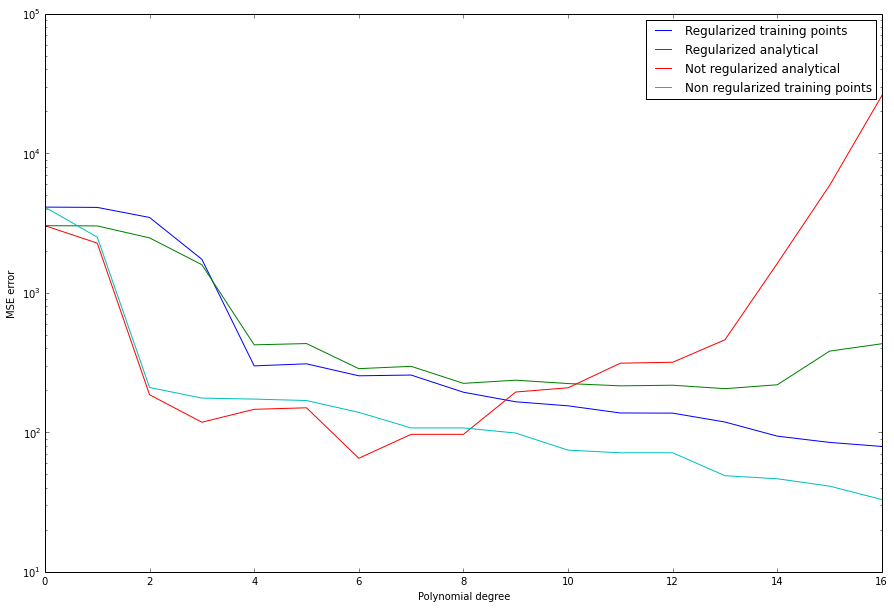

In [12]:
regularized_max_degree = 17
regularized_fits =  map(lambda degree: get_regularized_polynomial_fit(X, Y, 1e5, degree),
                        xrange(regularized_max_degree))
MSE_points_regularized = map(lambda fit: get_fit_MSE(fit, X, Y), regularized_fits)
MSE_real_regularized = map(get_model_MSE, regularized_fits)
fig, ax = pl.subplots(figsize=(screen_width, plot_height))
ax.plot(range(len(MSE_points_regularized)), MSE_points_regularized, label='Regularized training points')
ax.plot(range(len(MSE_real_regularized)), MSE_real_regularized, label='Regularized analytical')
ax.plot(range(len(MSE_real)), MSE_real, label='Not regularized analytical')
ax.plot(range(len(MSE_points_error)), MSE_points_error, label='Non regularized training points')
ax.set_yscale('log')
ax.set_ylabel("MSE error")
ax.set_xlabel("Polynomial degree")
ax.legend()

With right parameters it doesn't overfit, but the loss is greater (who might have thought).

## Cross-validation is imperfect
https://people.csail.mit.edu/romer/papers/CrossVal_SDM08.pdf


"In this paper we provide an empirical reminder
of a fact that is known but usually underestimated:
when the set of algorithms to be considered becomes
large, cross validation is no longer a good measure
of generalization performance, and accordingly can no
longer be used for algorithm or feature selection."

# scikit-learn
http://scikit-learn.org/stable/tutorial/statistical_inference/settings.html
## Datasets
Scikit-learn deals with learning information from one or more datasets that are represented as 2D arrays. They can be understood as a list of multi-dimensional observations. We say that the first axis of these arrays is the samples axis, while the second is the features axis.
### A simple example shipped with the scikit: iris dataset

In [13]:
from sklearn import datasets
iris = datasets.load_iris()
iris.data.shape

(150, 4)

It is made of 150 observations of irises, each described by 4 features: their sepal and petal length and width, as detailed in iris.DESCR.

When the data is not initially in the (n_samples, n_features) shape, it needs to be preprocessed in order to be used by scikit-learn.

## Estimators objects

Fitting data: the main API implemented by scikit-learn is that of the estimator. An estimator is any object that learns from data; it may be a classification, regression or clustering algorithm or a transformer that extracts/filters useful features from raw data.

All estimator objects expose a fit method that takes a dataset (usually a 2-d array). All the parameters of an estimator can be set when it is instantiated or by modifying the corresponding attribute.

In [14]:
from sklearn.tree import DecisionTreeClassifier

In [15]:
iris_tree = DecisionTreeClassifier(criterion='entropy')
iris_tree.fit(iris.data, iris.target)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')

## Scoring
sklearn implements a variety of quality metrics: http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics and a cross-validation routine

In [16]:
from sklearn.cross_validation import cross_val_score
cross_val_score(DecisionTreeClassifier(), iris.data, iris.target, 'f1_weighted')

array([ 0.98037518,  0.92156863,  1.        ])

## Pipelining & Grid search

Some estimators can transform data and that some estimators can predict variables. We can also create combined estimators:
http://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html#pipelining

In [17]:
from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV

logistic = linear_model.LogisticRegression()

# https://en.wikipedia.org/wiki/Principal_component_analysis
# Statistical procedure that uses an orthogonal transformation to convert 
# a set of observations of possibly correlated variables into a set of values
# of linearly uncorrelated variables called principal components. 
pca = decomposition.PCA() 
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

digits = datasets.load_digits()
X_digits = digits.data
y_digits = digits.target

n_components = [20, 40, 64]
Cs = np.logspace(-4, 4, 3)

# GridSearch - ehaustuive search for the best parameters using cross-validation
# We'll later look into better approaches
# Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components,
                              logistic__C=Cs))
estimator.fit(X_digits, y_digits)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('pca', PCA(copy=True, n_components=None, whiten=False)), ('logistic', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0))]),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'logistic__C': array([  1.00000e-04,   1.00000e+00,   1.00000e+04]), 'pca__n_components': [20, 40, 64]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

In [18]:
estimator.best_estimator_

Pipeline(steps=[('pca', PCA(copy=True, n_components=40, whiten=False)), ('logistic', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0))])

# Classifiers

## DecisionTree
http://scikit-learn.org/stable/auto_examples/tree/plot_iris.html#example-tree-plot-iris-py
Will be important later on for ensembles.

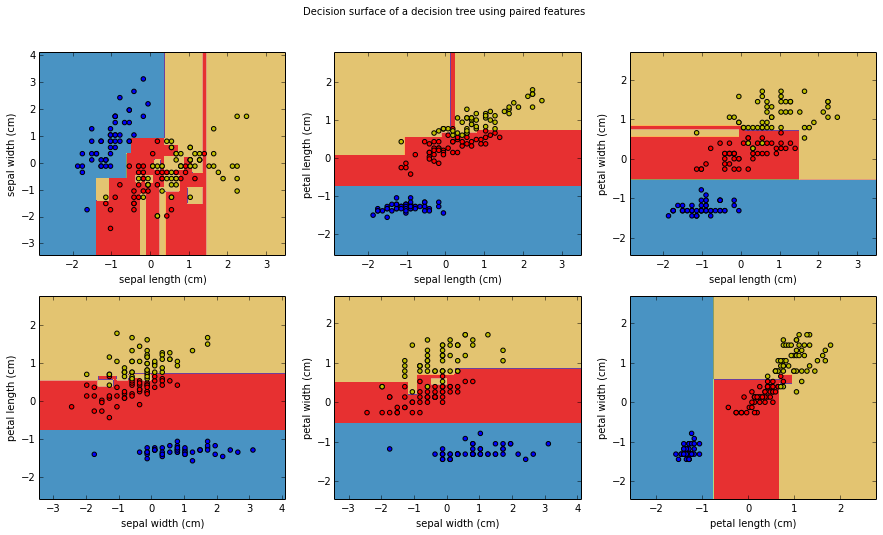

In [19]:
n_classes = 3
plot_colors = "bry"
plot_step = 0.02
import sklearn.preprocessing
def plot_decision_on_axes(clf, ax, features, labels, scale='linear'):
    X = sklearn.preprocessing.scale(features)
    clf.fit(X, labels)
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = ax.contourf(xx, yy, Z, cmap=plt.cm.Paired)

    plt.axis("tight")

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(labels == i)
        ax.scatter(X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired)

def plot_decision_surface(clf, fig):
    for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3],
                                    [1, 2], [1, 3], [2, 3]]):
        # We only take the two corresponding features
        X = iris.data[:, pair]
        y = iris.target

        # Shuffle
        idx = np.arange(X.shape[0])
        np.random.seed(13)
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]
     
        # Plot the decision boundary
        ax = fig.add_subplot(2, 3, pairidx + 1)        
        plot_decision_on_axes(clf, ax, X, y)
        ax.set_xlabel(iris.feature_names[pair[0]])
        ax.set_ylabel(iris.feature_names[pair[1]])

    fig.suptitle("Decision surface of a decision tree using paired features")
plot_decision_surface(DecisionTreeClassifier(), fig=plt.figure(figsize=(screen_width, 2*4)))

In [20]:
tree = DecisionTreeClassifier().fit(iris.data, iris.target)

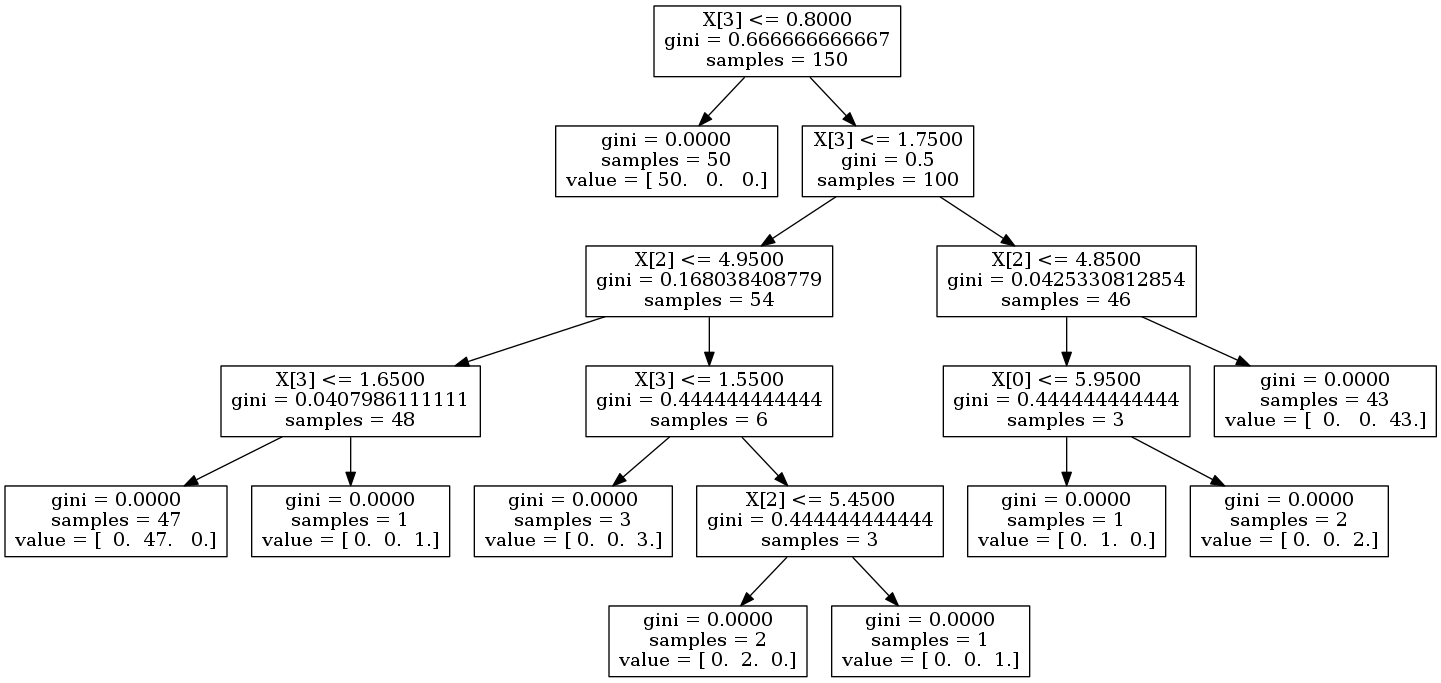

In [21]:
from sklearn.externals.six import StringIO  
import sklearn
import pydot
from IPython.display import Image
def draw_tree(clf):
    dot_data = StringIO() 
    sklearn.tree.export_graphviz(clf, out_file=dot_data) 
    graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
    png_str = graph.create_png(prog='dot')
    return Image(png_str)
draw_tree(tree)

Decision tree has paramenters (see lecture).

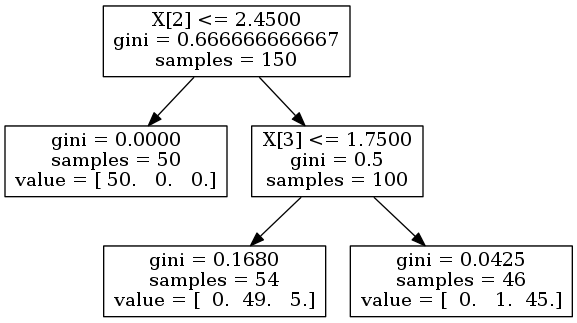

In [22]:
draw_tree(DecisionTreeClassifier(max_depth=2).fit(iris.data, iris.target))

SELF. Plot cross validation score of a DecisionTreeClassifier on iris as a function of max_depth. Bonus for errorbars.

## KNN

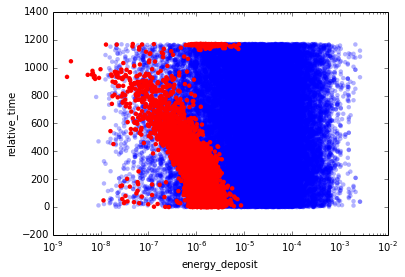

In [31]:
import pandas as pd
hits_train = pd.read_csv("~/data/train.csv")
candidates = hits_train.loc[(hits_train.energy_deposit > 0)]
plot_sample_indices = np.random.choice(np.arange(len(candidates)), size=50000)
hits_to_plot = candidates.iloc[plot_sample_indices]
fig, ax = plt.subplots()
signal_hits = hits_to_plot.loc[(hits_to_plot.label == 1)]
noise_hits = hits_to_plot.loc[(hits_to_plot.label == 2)]
ax.scatter(noise_hits.energy_deposit, noise_hits.relative_time, c='b', edgecolors='none', alpha=0.3)
ax.scatter(signal_hits.energy_deposit, signal_hits.relative_time, c='r', edgecolors='none')
ax.set_xscale('log')
ax.set_xlim(1e-9, 1e-2)
ax.set_xlabel("energy_deposit")
ax.set_ylabel("relative_time")

Naive application

In [32]:
from sklearn.cross_validation import cross_val_score

In [35]:
from sklearn.neighbors import KNeighborsClassifier
cross_val_score(KNeighborsClassifier(), candidates[['energy_deposit', 'relative_time']].values, 
               (candidates.label == 1).values, n_jobs=2, cv=4, scoring='roc_auc')

array([ 0.63574086,  0.6356973 ,  0.63501769,  0.63849355])

Not good. Metric classifiers need good metrics. We have features of different magnitude - let's try canberra.

In [36]:
n_samples = 100000
print cross_val_score(KNeighborsClassifier(metric='minkowski'),
                      candidates.loc[:n_samples, ['energy_deposit', 'relative_time']],
                      (candidates.label == 1).loc[:n_samples], n_jobs=2, scoring='roc_auc', cv=3)
print cross_val_score(KNeighborsClassifier(metric='canberra', algorithm="ball_tree"),
                candidates.loc[:n_samples, ['energy_deposit', 'relative_time']], 
               (candidates.label == 1).loc[:n_samples], n_jobs=2, scoring='roc_auc', cv=3)
print float(n_samples)/len(candidates)

[ 0.63960729  0.63322997  0.64554349]
[ 0.95667728  0.9561199   0.94269115]
0.0852393563747


Even with just 8% of the sample canberra metric gives grossly better result than minkowski.

In [37]:
def plot_decision_on_axes_v2(clf, ax, features, labels, scale=True, mesh_space=(np.linspace, np.linspace),
                          mesh_points=50, plot_colors = "bry", scatter_args={}):
    if scale:
        X = scale(features)
    else:
        X = features
    n_classes = len(set(labels))
    clf.fit(X, labels)
    xx, yy = np.meshgrid(*[space(X[:, feature].min(), X[:, feature].max(), num=mesh_points) for \
                            feature, space in enumerate(mesh_space)])

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = ax.contourf(xx, yy, Z, cmap=plt.cm.Paired, linewidth=3,
                     levels=np.linspace(0, n_classes, num=n_classes+2, endpoint=False))

    plt.axis("tight")
    
    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(labels == i)
        ax.scatter(X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired, **scatter_args)

In [38]:
def logspace_real_start_stop(min_, max_, base=10, **kwargs):
    return np.logspace(np.log(min_)/np.log(base), np.log(max_)/np.log(base), **kwargs)

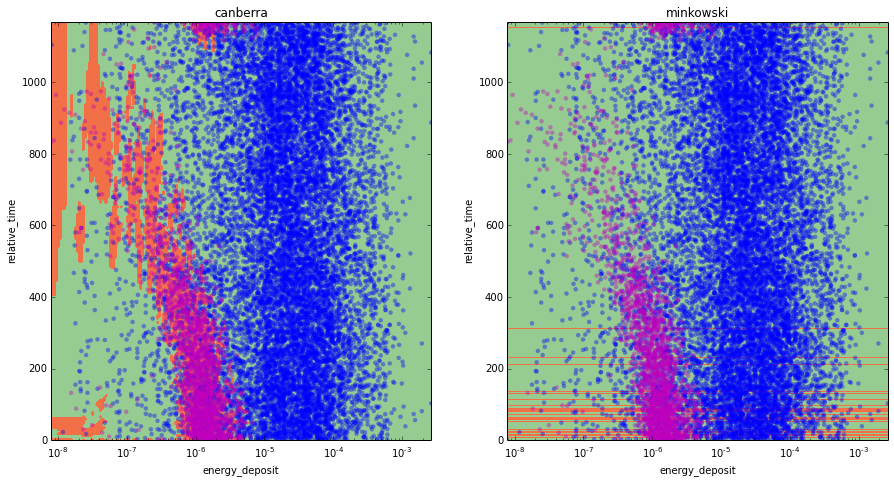

In [39]:
fig = plt.figure(figsize=(screen_width, 0.5*screen_width))
ax = fig.add_subplot(1, 2, 1)
plot_decision_on_axes_v2(KNeighborsClassifier(metric='canberra', algorithm="ball_tree"), ax,
                      candidates.loc[:n_samples, ['energy_deposit', 'relative_time']].values, 
                     (candidates.label == 1).loc[:n_samples].values, scale=False, 
                      mesh_space=(logspace_real_start_stop, np.linspace), plot_colors = "bmy",
                      mesh_points=200,
                      scatter_args={'alpha': 0.4, 'edgecolor': 'none'})
ax.set_xscale('log')
ax.set_xlabel("energy_deposit")
ax.set_ylabel("relative_time")
ax.set_title("canberra")

ax_minkowski = fig.add_subplot(1, 2, 2)
plot_decision_on_axes_v2(KNeighborsClassifier(metric='minkowski'), ax_minkowski,
                      candidates.loc[:n_samples, ['energy_deposit', 'relative_time']].values, 
                     (candidates.label == 1).loc[:n_samples].values, scale=False, 
                      mesh_space=(logspace_real_start_stop, np.linspace), plot_colors = "bmy",
                      mesh_points=500,
                      scatter_args={'alpha': 0.4, 'edgecolor': 'none'})
ax_minkowski.set_xscale('log')
ax_minkowski.set_xlabel("energy_deposit")
ax_minkowski.set_ylabel("relative_time")
ax_minkowski.set_title("minkowski")

In [40]:
transformed_energy = np.log(candidates.energy_deposit)**2
transformed_time = candidates.relative_time**2
from sklearn.preprocessing import StandardScaler

In [41]:
scale_knn = Pipeline(steps=[('scale', StandardScaler()), ('knn', KNeighborsClassifier())])
comet_transformed_features = np.concatenate(
        (transformed_energy[:, np.newaxis], transformed_time[:, np.newaxis]), axis=1)
comet_transformed_target = (candidates.label == 1).values
scale_knn_cv = cross_val_score(scale_knn, comet_transformed_features, comet_transformed_target,
                n_jobs=-1, scoring='roc_auc')
print scale_knn_cv.mean(), scale_knn_cv.std()

0.95386913852 0.000864356921866


Good!
## Logistic regression
It can beat ensemble - if data is linearly separable.

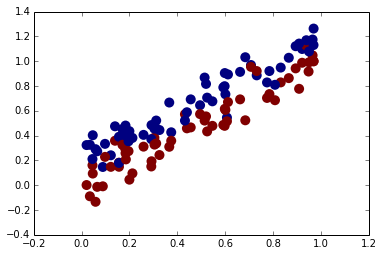

In [42]:
np.random.seed(42)
x_space = np.random.uniform(0, 1, size=60)
y0 = x_space + 0.2 + np.random.normal(size=len(x_space), scale=0.1)
y1 = x_space + np.random.normal(size=len(x_space), scale=0.1)
shuffle = np.random.permutation(2*len(x_space))
features = np.concatenate((np.concatenate((x_space, x_space))[:, np.newaxis],
                          np.concatenate((y0, y1))[:, np.newaxis]), axis=1)[shuffle]
labels = np.concatenate((np.zeros(len(y0)), np.ones(len(y1))))[shuffle]
fig, ax = pl.subplots()
ax.scatter(features[:, 0], features[:, 1], c=labels, edgecolors='none', s=100)

In [43]:
from sklearn.ensemble import RandomForestClassifier
rf_cv = cross_val_score(RandomForestClassifier(), features, labels, cv=5)
print rf_cv.mean(), rf_cv.std()

0.6 0.0971825315808


In [44]:
from sklearn.linear_model import LogisticRegression
linear_cv = cross_val_score(LogisticRegression(), features, labels, cv=5)
print linear_cv.mean(), linear_cv.std()

0.766666666667 0.0971825315808


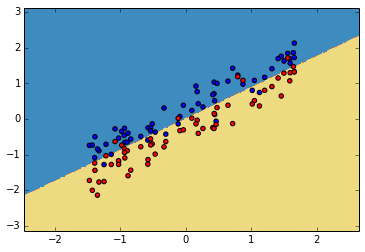

In [45]:
fig, ax = pl.subplots()
plot_decision_on_axes(LogisticRegression(), ax, features, labels)

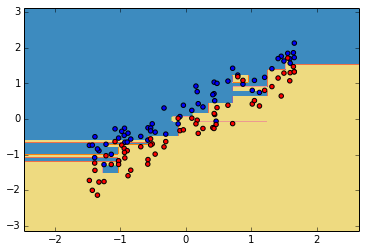

In [46]:
fig, ax = pl.subplots()
plot_decision_on_axes(DecisionTreeClassifier(), ax, features, labels)

# Learning curve
http://scikit-learn.org/stable/modules/learning_curve.html
A learning curve shows the validation and training score of an estimator for varying numbers of training samples. It is a tool to find out how much we benefit from adding more training data. If both the validation score and the training score converge to a value that is too low with increasing size of the training set, we will not benefit much from more training data.

In [47]:
# Just for fun we'll implement it here
# But you can use sklearn.learning_curve.learning_curve
from sklearn.cross_validation import KFold
from sklearn.metrics.scorer import check_scoring
from sklearn.base import clone
def learning_curve(clf, X, y, scoring, cv, train_sizes=np.array([ 0.1, 0.325, 0.55, 0.775, 1.])):
    """
    Calculates the lerning curve. Presumes data is already shuffled.
    
    Args:
        clf - Sklear classifier to use.
        X - features, np.array, shape (n_items, n_features)
        y - labels, np.array, shape (n_items)
        scoring - string, callable or None, optional, default: None 
            A string (see sklearn model evaluation documentation) or
            a scorer callable object / function with signature scorer(estimator, X, y).
        cv - number of folds to use
        train_sizes - array-like, shape (n_ticks,), dtype float 
            Relative or numbers of training examples that will be used to generate the learning curve.
    Returns:
        train_sizes_abs : array, shape = (n_unique_ticks,), dtype int
            Numbers of training examples that has been used to generate 
            the learning curve.
        train_scores : array, shape (n_ticks, n_cv_folds)
            Scores on training sets.
        test_scores : array, shape (n_ticks, n_cv_folds)
            Scores on test set.
    """
    sizes = np.around(train_sizes*X.shape[0]).astype(np.int)
    train_scores = list()
    test_scores = list()
    scorer = check_scoring(clf, scoring=scoring)
    for size in sizes:
        kf = KFold(size, n_folds=cv)
        train_scores.append(list())
        test_scores.append(list())
        for train_indices, test_indices in kf:
            estimator = clone(clf)
            estimator.fit(X[train_indices, :], y[train_indices])
            train_scores[-1].append(scorer(estimator,  X[train_indices, :], y[train_indices]))
            test_scores[-1].append(scorer(estimator,  X[test_indices, :], y[test_indices]))
    return (sizes, np.array(train_scores), np.array(test_scores))

In [48]:
knn_comet_learning_curve_sizes, knn_comet_learning_curve_train, knn_comet_learning_curve_test = \
    learning_curve(KNeighborsClassifier(), comet_transformed_features, comet_transformed_target,
                  scoring='roc_auc', cv=4)

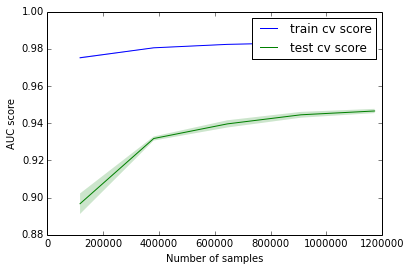

In [49]:
#http://nbviewer.ipython.org/github/donnemartin/data-science-ipython-notebooks/blob/master/scikit-learn/scikit-learn-validation.ipynb
def plot_with_err(x, data, axis, **kwargs):
    mu, std = data.mean(axis=1), data.std(axis=1)
    lines = axis.plot(x, mu, '-', **kwargs)
    axis.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)
fig, ax = pl.subplots()
plot_with_err(knn_comet_learning_curve_sizes, knn_comet_learning_curve_train, ax, label="train cv score")
plot_with_err(knn_comet_learning_curve_sizes, knn_comet_learning_curve_test, ax, label="test cv score")
ax.set_xlabel("Number of samples")
ax.set_ylabel("AUC score")
ax.legend()

#Feature engineering
It is the process of transforming raw data into features that better represent the underlying problem to the predictive models, resulting in improved model accuracy on unseen data.

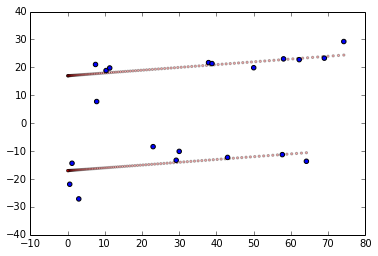

In [ ]:
engineered_y = Y/X
engineered_x = X**2
fig, ax = pl.subplots()
x_space = np.linspace(X.min(), X.max(), num=200)
ax.scatter(x_space**2, Y_ideal(x_space)/x_space, marker='.', c='r', alpha=0.3)
ax.scatter(engineered_x, engineered_y) 

http://habrahabr.ru/post/249759/

http://nbviewer.ipython.org/github/aguschin/kaggle/blob/master/forestCoverType_featuresEngineering.ipynb

In [39]:
from sklearn.datasets import fetch_covtype
covtype = fetch_covtype()

http://archive.ics.uci.edu/ml/datasets/Covertype/machine-learning-databases/covtype/covtype.info
Attribute Information:

Given is the attribute name, attribute type, the measurement unit and a brief description. The forest cover type is the classification problem. The order of this listing corresponds to the order of numerals along the rows of the database. 

Name / Data Type / Measurement / Description
1. Elevation / quantitative /meters / Elevation in meters
2. Aspect / quantitative / azimuth / Aspect in degrees azimuth 
3. Slope / quantitative / degrees / Slope in degrees
4. Horizontal_Distance_To_Hydrology / quantitative / meters / Horz Dist to nearest surface water features
5. Vertical_Distance_To_Hydrology / quantitative / meters / Vert Dist to nearest surface water features 
6. Horizontal_Distance_To_Roadways / quantitative / meters / Horz Dist to nearest roadway 
7. Hillshade_9am / quantitative / 0 to 255 index / Hillshade index at 9am, summer solstice 
8. Hillshade_Noon / quantitative / 0 to 255 index / Hillshade index at noon, summer soltice 
9. Hillshade_3pm / quantitative / 0 to 255 index / Hillshade index at 3pm, summer solstice 
10. Horizontal_Distance_To_Fire_Points / quantitative / meters / Horz Dist to nearest wildfire ignition points 
11. Wilderness_Area (4 binary columns) / qualitative / 0 (absence) or 1 (presence) / Wilderness area designation 
12. Soil_Type (40 binary columns) / qualitative / 0 (absence) or 1 (presence) / Soil Type designation 
13. Cover_Type (7 types) / integer / 1 to 7 / Forest Cover Type designation

In [40]:
covtype['data'].shape

(581012, 54)

In [41]:
qualitive_features_names = [
    "Elevation",
    "Aspect",
    "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"]
feature_names = qualitive_features_names + \
    map(lambda i: "Wilderness_Area_%d" % i, xrange(4)) + \
    map(lambda i: "Soil_Type_%d" % i, xrange(40))
print len(feature_names)

54


In [42]:
from astroML.plotting import hist
from itertools import izip

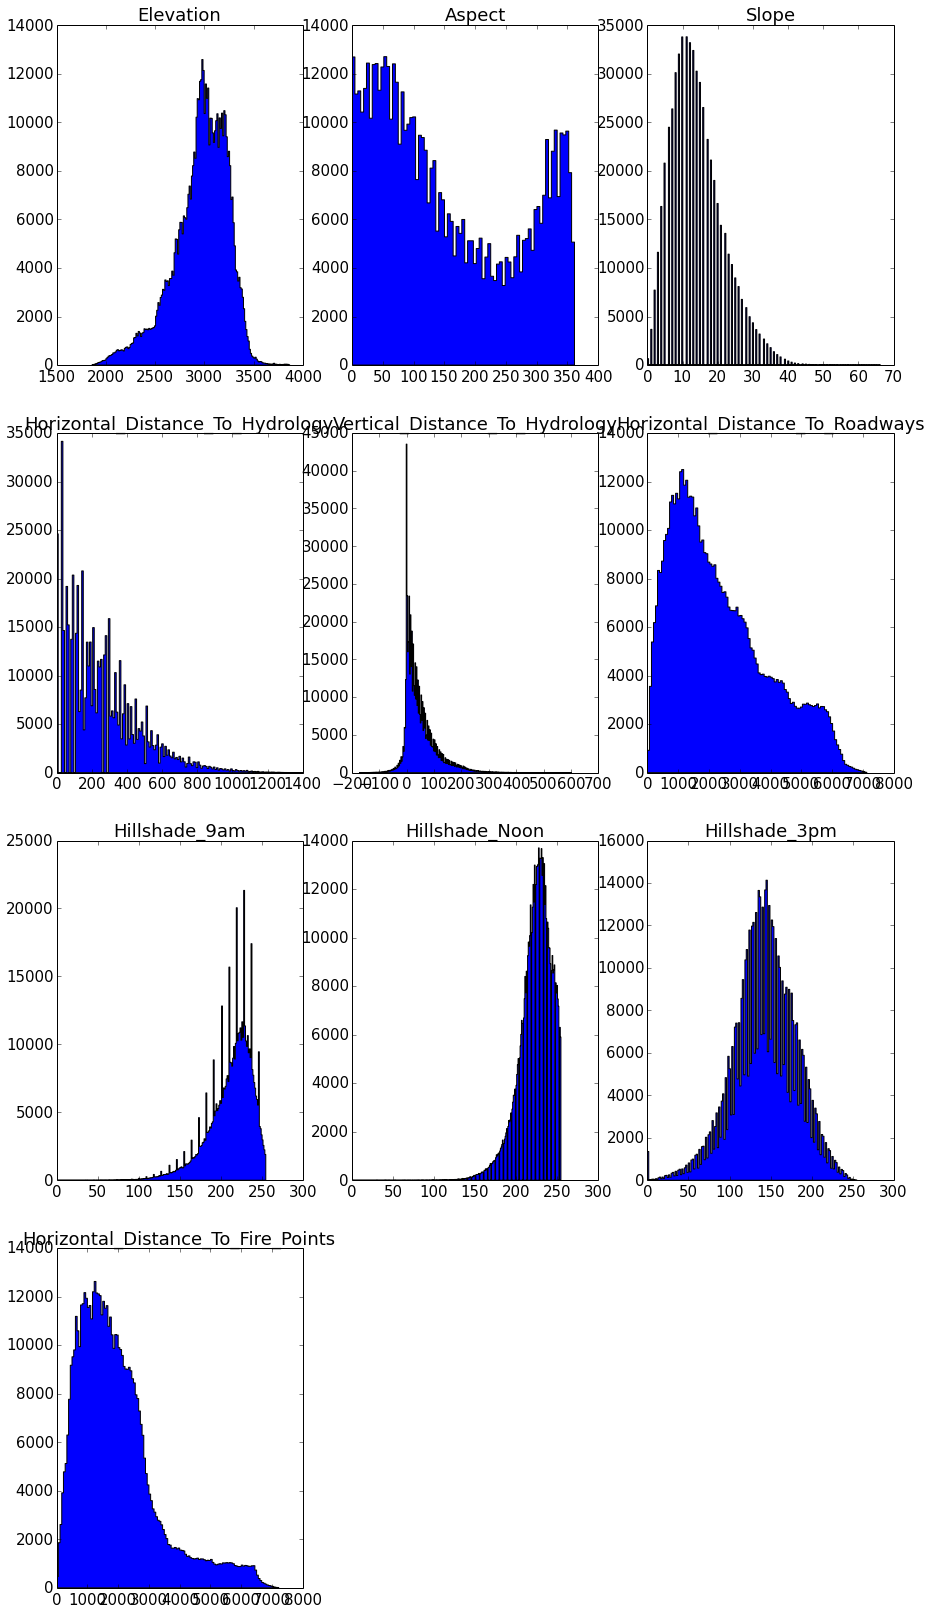

In [43]:
rows = np.ceil(len(qualitive_features_names) / 3.0) 
fig = pl.figure(figsize=(screen_width, rows * plot_height * 0.7))
for index, (data, name) in enumerate(izip(covtype['data'].T, qualitive_features_names)):
    ax = fig.add_subplot(rows, 3, index + 1)
    hist(data, ax=ax, bins='scott', histtype='stepfilled')
    ax.set_title(name)

# Idea:
1. Engineer features
2. Loook at cross-validation score
3. Look at features importances
4. Leave the best
5. GoTo 1

SELF. Let's test whether DecisionTree.feature\_importances_ makes sense. Try excluding a feature, then doing cross-validation. See if there is a relationship between the cross validation result and feature importance indicated by decision tree. This might take some time, you can take top 8 and bottom 3 by tree feature importance estimate.

In [44]:
from sklearn.cross_validation import cross_val_score
from sklearn.tree import DecisionTreeClassifier
tree = RandomForestClassifier(criterion='entropy')
tree.fit(covtype.data, covtype.target)
feature_importances = tree.feature_importances_.copy()

In [45]:
features_sorted = np.argsort(feature_importances)
features_to_test = np.concatenate((features_sorted[:3], features_sorted[-8:]))
cv_scores = np.empty(shape=features_sorted.shape)
cv_scores_std = np.empty(shape=features_sorted.shape)
for feature in features_to_test:
    feature_mask = np.ones(shape=covtype.data.shape[1], dtype=bool)
    feature_mask[feature] = False
    cv_score = cross_val_score(
            tree, covtype.data[:, feature_mask], covtype.target, scoring='accuracy', n_jobs=-1, cv=4)
    cv_scores[feature] = np.mean(cv_score)
    cv_scores_std[feature] = np.std(cv_score)
    print("%s, cv = %g, tree importance=%g" % (
        feature_names[feature], cv_scores[feature], feature_importances[feature]))

Soil_Type_14, cv = 0.589909, tree importance=5.06086e-06
Soil_Type_6, cv = 0.589974, tree importance=1.30054e-05
Soil_Type_7, cv = 0.592377, tree importance=4.061e-05
Hillshade_Noon, cv = 0.600055, tree importance=0.0359923
Aspect, cv = 0.600995, tree importance=0.0415618
Vertical_Distance_To_Hydrology, cv = 0.592303, tree importance=0.0506283
Wilderness_Area_3, cv = 0.578557, tree importance=0.0525244
Horizontal_Distance_To_Hydrology, cv = 0.57635, tree importance=0.0534276
Horizontal_Distance_To_Fire_Points, cv = 0.603631, tree importance=0.0998056
Horizontal_Distance_To_Roadways, cv = 0.571402, tree importance=0.113105
Elevation, cv = 0.53197, tree importance=0.247257


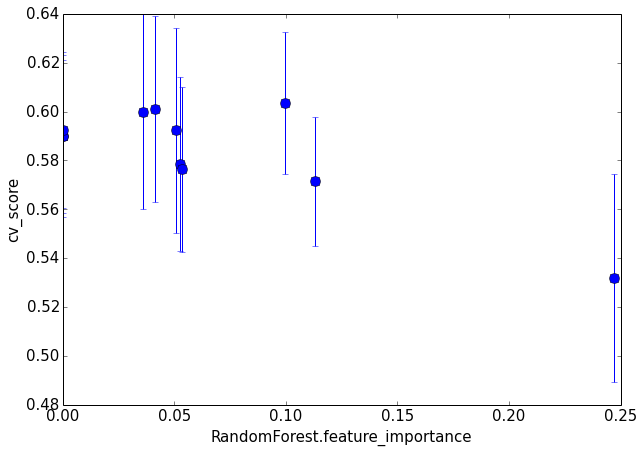

In [46]:
fig, ax = pl.subplots()
ax.errorbar(feature_importances[features_to_test], cv_scores[features_to_test], 
            yerr=cv_scores_std[features_to_test], fmt='o', ms=10)
ax.set_ylabel('cv_score')
ax.set_xlabel('RandomForest.feature_importance')

In [47]:
from itertools import imap, chain

In [48]:
def transpose_column(column):
    if len(column.shape) == 1:
        return column[:, np.newaxis]
    else:
        return column
        
def attach_columns(array, *columns):
    # Bonus if you rewrite without the [:, np.newaxis] hack. I gave up.
    return np.concatenate([array, ] + map(transpose_column, columns), axis=1)

In [68]:
from sklearn.ensemble import RandomForestClassifier
def try_cv_with_features(*features):
    tree = RandomForestClassifier(criterion='entropy', n_jobs=-1, n_estimators=25)
    combined_features = attach_columns(covtype['data'], *features)
    cv_score = cross_val_score(tree, combined_features,
                               covtype['target'], scoring='accuracy', cv=4)
    print 'Score mean: %.3f, std: %.3f' % (np.mean(cv_score), np.std(cv_score))
    tree.fit(combined_features, covtype['target'])
    fig, ax = pl.subplots()
    hist(tree.feature_importances_, bins=20, ax=ax)
    # Mark the importance of added features
    added_features_number = sum(imap(lambda feature: 1 if len(feature.shape) == 1 else feature.shape[1],
                                    features))
    for value in tree.feature_importances_[-added_features_number:]:
        ax.axvline(x = value, c='r')
    print tree.feature_importances_[-added_features_number:]

In [69]:
data = pd.DataFrame(covtype['data'], columns=feature_names)

Without engineered features.

Score mean: 0.605, std: 0.037
[  2.71415695e-01   4.09180902e-02   2.90881073e-02   5.23580957e-02
   5.03459735e-02   1.15134497e-01   3.51461478e-02   3.69541140e-02
   3.52200823e-02   1.00409555e-01   2.73276074e-02   6.84314716e-03
   1.63048724e-02   3.36170484e-02   5.48753521e-04   8.90891831e-03
   3.01693940e-03   1.43240047e-02   3.35959237e-04   1.37356927e-03
   1.39063202e-05   2.86300695e-05   2.04782938e-04   1.36249654e-02
   3.66919676e-03   4.66518609e-03   4.62320604e-03   2.85970699e-04
   2.62184926e-06   6.30425200e-04   1.94352640e-03   3.12436881e-04
   9.04912951e-04   1.77861138e-03   4.66383327e-04   9.13313981e-03
   8.41896868e-03   3.95469696e-03   1.08083763e-04   6.16884724e-04
   4.75307045e-04   2.16433613e-04   6.22062070e-03   4.02105869e-03
   3.85333428e-03   6.15629571e-03   5.08207409e-03   5.02279432e-04
   1.71032622e-03   8.89902935e-05   5.63278507e-04   1.48837023e-02
   1.48771853e-02   6.37140017e-03]


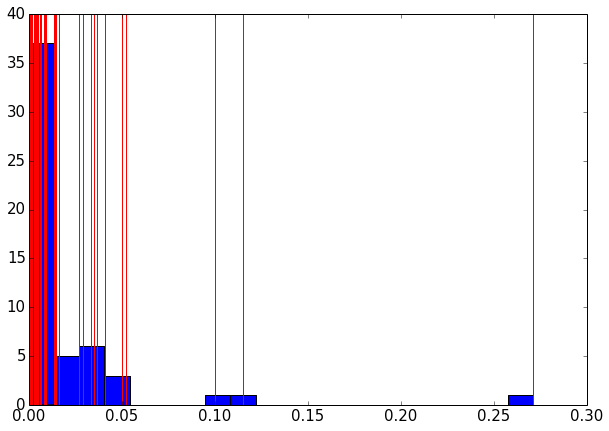

In [70]:
try_cv_with_features()

In [71]:
has_negative_vertical_distance = data.Vertical_Distance_To_Hydrology < 0

In [72]:
distance_to_hydrology = np.sqrt(data.Vertical_Distance_To_Hydrology**2 +
                                data.Horizontal_Distance_To_Hydrology**2)

Score mean: 0.605, std: 0.034
[ 0.00368128  0.04242362]


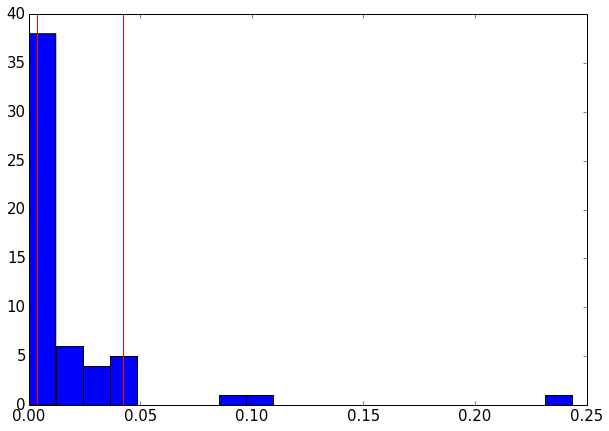

In [73]:
try_cv_with_features(has_negative_vertical_distance, distance_to_hydrology)

Hm. "Has vertical distance" is useless. Logical - tree can pick up such dependencies by itself.

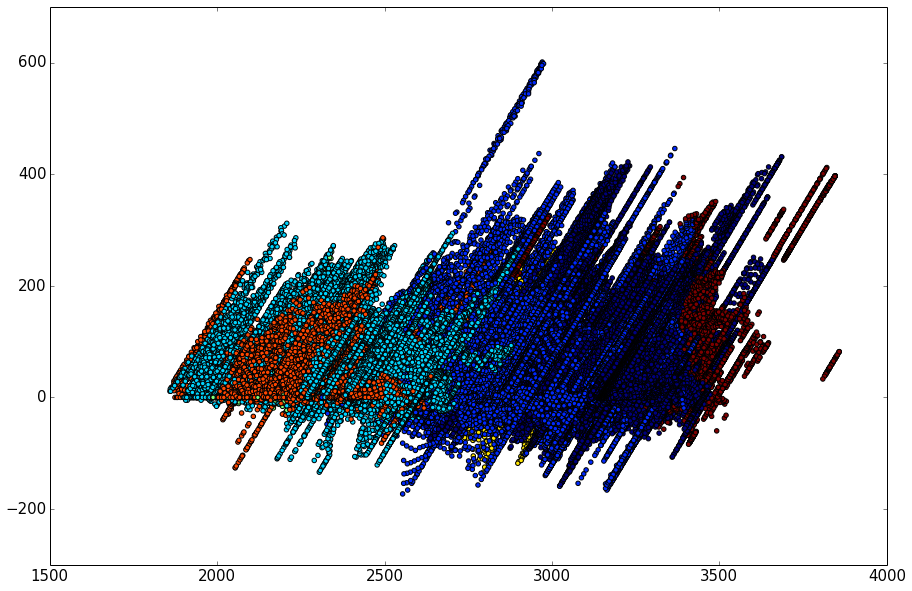

In [74]:
fig, ax = pl.subplots(figsize=(screen_width, plot_height))
ax.scatter(data.Elevation, data.Vertical_Distance_To_Hydrology, c=covtype['target'])

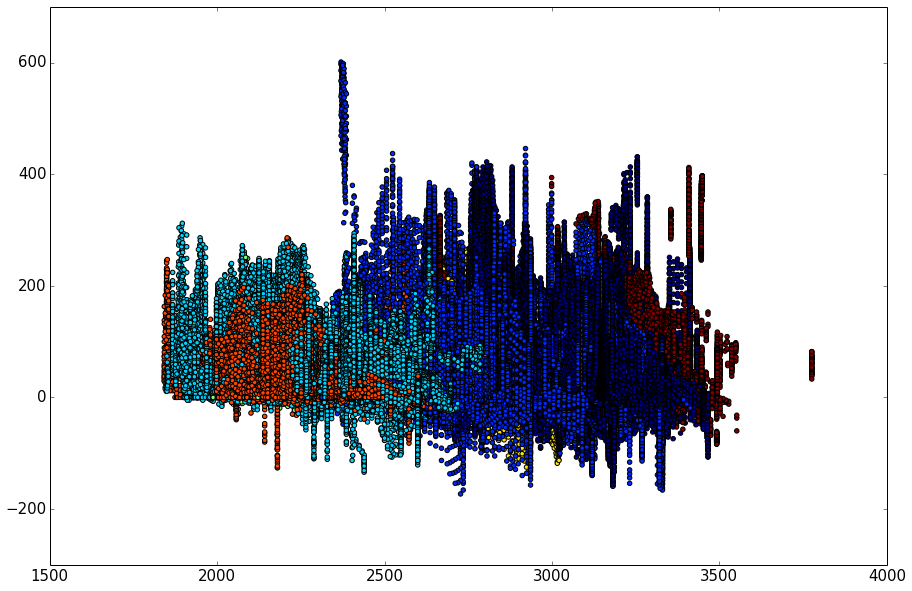

In [75]:
fig, ax = pl.subplots(figsize=(screen_width, plot_height))
ax.scatter(data.Elevation - data.Vertical_Distance_To_Hydrology,
           data.Vertical_Distance_To_Hydrology, c=covtype['target'])
# And we all know that Decision trees are much better at selecting rectangulars

In [76]:
elevation_plus_vd = data.Vertical_Distance_To_Hydrology + data.Elevation

In [77]:
elevation_minus_vd =  - data.Vertical_Distance_To_Hydrology + data.Elevation

Score mean: 0.613, std: 0.028
[ 0.00262221  0.03571279  0.1138818   0.16378454]


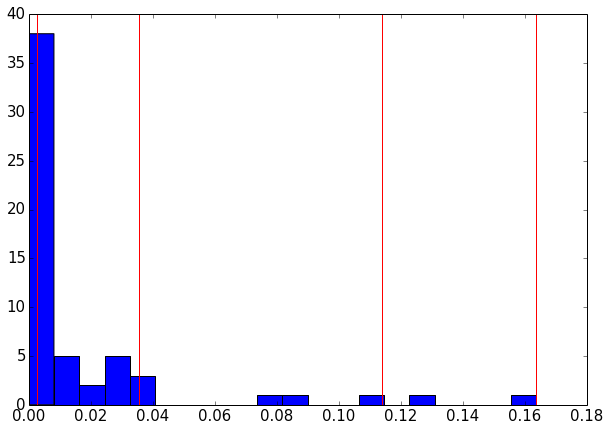

In [78]:
try_cv_with_features(has_negative_vertical_distance, distance_to_hydrology, elevation_plus_vd, elevation_minus_vd)

Automated approach.

In [79]:
pd.DataFrame(feature_importances, index=feature_names).sort([0], ascending=False)[:10]

,0
Elevation,0.247257
Horizontal_Distance_To_Roadways,0.113105
Horizontal_Distance_To_Fire_Points,0.099806
Horizontal_Distance_To_Hydrology,0.053428
Wilderness_Area_3,0.052524
Vertical_Distance_To_Hydrology,0.050628
Aspect,0.041562
Hillshade_Noon,0.035992
Hillshade_3pm,0.035289
Hillshade_9am,0.035102


Let's add and subtract all the distances.

In [80]:
from itertools import combinations
auto_engineered_disances = pd.DataFrame()
for (feature_one, feature_two) in combinations(features_sorted[-5:], r=2):
    for name, operation in zip(("plus", "minus"), (np.add, np.subtract, np.true_divide)):
        new_name = "%s_%s_%s" % (feature_names[feature_one], name, feature_names[feature_two])
        auto_engineered_disances[new_name] = operation(covtype.data[:, feature_one],
                                                       covtype.data[:, feature_two])

In [81]:
auto_engineered_disances.columns

Index([u'Wilderness_Area_3_plus_Horizontal_Distance_To_Hydrology',
       u'Wilderness_Area_3_minus_Horizontal_Distance_To_Hydrology',
       u'Wilderness_Area_3_plus_Horizontal_Distance_To_Fire_Points',
       u'Wilderness_Area_3_minus_Horizontal_Distance_To_Fire_Points',
       u'Wilderness_Area_3_plus_Horizontal_Distance_To_Roadways',
       u'Wilderness_Area_3_minus_Horizontal_Distance_To_Roadways',
       u'Wilderness_Area_3_plus_Elevation',
       u'Wilderness_Area_3_minus_Elevation',
       u'Horizontal_Distance_To_Hydrology_plus_Horizontal_Distance_To_Fire_Points',
       u'Horizontal_Distance_To_Hydrology_minus_Horizontal_Distance_To_Fire_Points',
       u'Horizontal_Distance_To_Hydrology_plus_Horizontal_Distance_To_Roadways',
       u'Horizontal_Distance_To_Hydrology_minus_Horizontal_Distance_To_Roadways',
       u'Horizontal_Distance_To_Hydrology_plus_Elevation',
       u'Horizontal_Distance_To_Hydrology_minus_Elevation',
       u'Horizontal_Distance_To_Fire_Points_plus_Hori

Score mean: 0.621, std: 0.027
[ 0.01274415  0.01080537  0.00960412  0.01828054  0.01938835  0.02010348
  0.01933114  0.09404637  0.0840429   0.02189222  0.01919983  0.02064184
  0.02479209  0.04051825  0.04848501  0.03589947  0.02673837  0.02759191
  0.02197939  0.02942639  0.02535803]


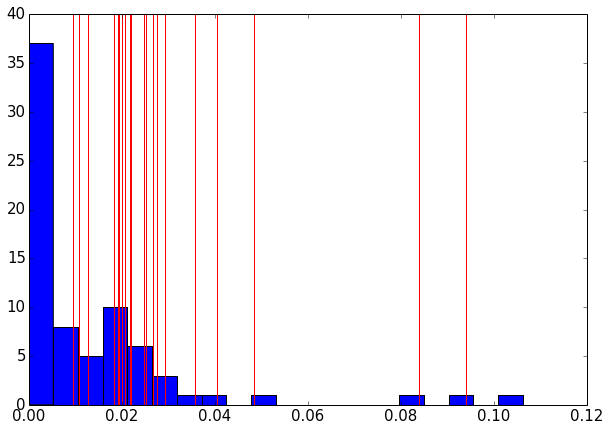

In [82]:
try_cv_with_features(distance_to_hydrology, auto_engineered_disances.values)

# How to win at Kaggle
http://blog.kaggle.com/2014/08/01/learning-from-the-best/
http://blog.kaggle.com/category/dojo/

'1. Feature engineering is often the most important part

'2. Simple models will get you far.

'3. Overfitting the leaderboard is a real issue

'4. Ensembling is a winning strategy (see tomorrow)

'5. Predicting the right thing is important

# COMET.

SELF. Use feature engineering to improve your model. Ideas:
  1. Wire distance from center
  2. Some function of neighbours as a feature
  3. https://gist.github.com/arogozhnikov/e6b158cad6353e7026ac
  4. http://www.hse.ru/data/2015/06/01/1097823680/290515_EwenG_comet_at_HSE.pdf
  5. https://indico.cern.ch/event/398008/contribution/0/attachments/1123631/1603393/090715_EwenG_student_seminar_0.pdf